In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from sklearn.ensemble import IsolationForest
from functools import reduce
import sys

sys.path.append("../src")
from utils import *

ModuleNotFoundError: No module named 'matplotlib.pylot'

In [ ]:
pd.set_option("display.max_columns", None)

# 1). Exploratory data analysis

In [ ]:
df = pd.read_csv("ecommerce_dataset.csv", sep=";")
df["datetime"] = pd.to_datetime(df["Timestamp"], unit="s")
df

In [ ]:
for col in ["Product category", "Environment", "Device type", "User location",
           "Browser family", "Existing client"]:
    print(col)
    print(df[col].value_counts(dropna=False))
    print("\n")

# 2). Granularity analysis

## 2). 1). Daily revenues

In [ ]:
df_revenues = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_revenues["revenue"] = (
    df_revenues["price"] * 
    df_revenues["quantity"]
)

df_revenues["datetime"] = df_revenues["datetime"].dt.date 

full_date_range = pd.date_range(
    start=df_revenues.datetime.min(),
    end=df_revenues.datetime.max(),
    freq="D"
)

missing_dates = (
    full_date_range.difference(df_revenues.datetime)
)


df_revenues.head()

In [ ]:
df_revenues = df_revenues[["datetime", "revenue"]]

df_revenues = (
    df_revenues.groupby(["datetime"],
                       as_index=False).agg({"revenue":"sum"})
)

df_revenues.set_index("datetime", inplace=True)

for missing_date in missing_dates:
    df_revenues.loc[missing_date.date(), "revenue"] = np.nan

df_revenues.sort_index(inplace=True)

df_revenues.head()

## 2). 2). Weekly revenues

In [ ]:
df_revenues_weekly = df_revenues.copy(deep=True).reset_index()
df_revenues_weekly["datetime"] = pd.to_datetime(df_revenues_weekly["datetime"])
df_revenues_weekly.set_index("datetime", inplace=True)
df_revenues_weekly = df_revenues_weekly.resample("W-MON", label="left").agg({
    "revenue":["sum", "size"]
})
df_revenues_weekly = df_revenues_weekly.iloc[1:-1]
df_revenues_weekly = df_revenues_weekly[[("revenue", "sum")]]
df_revenues_weekly.columns = ["revenue"]
df_revenues_weekly.head()

## 2). 3). Monthly revenues

In [ ]:
df_revenues_monthly = df_revenues.copy(deep=True).reset_index()
df_revenues_monthly["datetime"] = pd.to_datetime(df_revenues_monthly["datetime"])
df_revenues_monthly.set_index("datetime", inplace=True)
df_revenues_monthly = df_revenues_monthly.resample("MS").agg({
    "revenue":["sum", "size"]
})
df_revenues_monthly = (
df_revenues_monthly.iloc[1:-1]
)
df_revenues_monthly = df_revenues_monthly[[("revenue", "sum")]]
df_revenues_monthly.columns = ["revenue"]
df_revenues_monthly.head()

## 2). 4). Daily 7-day average revenues

In [ ]:
df_revenues_avg = df_revenues.copy(deep=True)
df_revenues_avg["revenue"] = (
    df_revenues_avg["revenue"].rolling(window=7, min_periods=1).mean()
)
df_revenues_avg.head()

In [ ]:
dict_granularity = {
    "daily":df_revenues,
    "rolling_avg":df_revenues_avg,
    "weekly":df_revenues_weekly,
    "monthly":df_revenues_monthly
}

dict_periods = {
    "daily":365,
    "rolling_avg":365,
    "weekly":52,
    "monthly":12
}

# 3). Evolution of the revenue during the year

## 3). 1). Levels

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.lineplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 2). Distributions

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
for i, granularity in enumerate(["daily", "rolling_avg", "weekly", "monthly"]):
    sns.histplot(dict_granularity[granularity]["revenue"],
                ax=ax[i//2][i%2])

## 3). 3). STL decomposition

In [ ]:
stl = STL(dict_granularity["daily"]["revenue"].dropna(how="any"),
         period=dict_periods["daily"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [ ]:
stl = STL(dict_granularity["rolling_avg"]["revenue"],
         period=dict_periods["rolling_avg"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [ ]:
stl = STL(dict_granularity["weekly"]["revenue"],
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

We choose weekly data or rolling average for findings trends and seasonality as its a tradeoff between smoothing week days vs. week ends dynamics and noise and giving more data points than monthly data that has for 1.5 years too few noise

## 3). 4). Weekly evolutions

In [ ]:
df_revenues_weekly["evolution_revenue_wow"]  =(
    df_revenues_weekly["revenue"].pct_change()
)

df_revenues_weekly["evolution_revenue_mom"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=4)
)

df_revenues_weekly["evolution_revenue_yoy"]  =(
    df_revenues_weekly["revenue"].pct_change(periods=52)
)

df_revenues_weekly[["evolution_revenue_wow",
                   "evolution_revenue_mom",
                   "evolution_revenue_yoy"]].plot()

In [ ]:
stl = STL(df_revenues_weekly["evolution_revenue_wow"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [ ]:
stl = STL(df_revenues_weekly["evolution_revenue_mom"].dropna(how="any"),
         period=dict_periods["weekly"])
result=stl.fit()
result.plot()
plt.tight_layout()

In [ ]:
print(f"Average WoW rate: {average_rate(df_revenues_weekly["evolution_revenue_wow"].dropna())*100} %")
print(f"Average MoM rate: {average_rate(df_revenues_weekly["evolution_revenue_mom"].dropna())*100} %")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(6,6))

sns.histplot(df_revenues_weekly["evolution_revenue_wow"], ax=ax[0])
sns.histplot(df_revenues_weekly["evolution_revenue_mom"], ax=ax[1])

## 3). 5). Contributions to the monthly evolutions

In [ ]:
df_contrib = (
df[df["Event type"]=="Sales"].copy(deep=True)
).rename(columns={"Product Price":"price", "Product quantity":"quantity"})

df_contrib["revenue"] = (
    df_contrib["price"] * 
    df_contrib["quantity"]
)

df_contrib["datetime"] = df_contrib["datetime"].dt.date

df_contrib = (
    df_contrib[["datetime", "revenue", "User location", "Device type", "Browser family", 
               "Environment", "Product category", "Existing client"]]
)

dict_contrib = {}

for col in ["User location", "Device type", "Browser family", "Environment",
           "Product category", "Existing client"]:
    dict_contrib[col] = (
        df_contrib.pivot_table(
            index="datetime",
            values="revenue",
            columns=col,
            aggfunc="sum"
        ).add_prefix(f"{col}_")
    )

    dict_contrib[col].index = (
        pd.to_datetime(dict_contrib[col].index)
    )


    dict_contrib[col] = (
        dict_contrib[col].resample("MS").sum()
    )

# We merge the different ventilations to get contributions
df_contrib_all = (
reduce(lambda left, right: pd.merge(left,
                                   right,
                                   left_index=True,
                                   right_index=True,
                                   how="outer"),
      list(dict_contrib.values()))
)

df_contrib = df_contrib[["datetime", "revenue"]].set_index("datetime")
df_contrib.index = pd.to_datetime(df_contrib.index)
df_contrib = df_contrib.resample("MS").sum()
df_contrib = df_contrib.iloc[1:-1]

df_contrib_all = (
    df_contrib_all.merge(df_contrib,
                        left_index=True,
                        right_index=True,
                        how="outer")
)

#We compute the contributions
for col in ["User location", "Device type", "Browser family", 
            "Environment","Product category", "Existing client"]:
    for col_ in [_ for _ in df_contrib_all.columns
                if _.startswith(col)]:

        df_contrib_all[f"contrib_{col_}"] = (
            df_contrib_all[col_].shift(1)/df_contrib_all["revenue"].shift(1)
            *df_contrib_all[col_].pct_change()
        )

df_contrib_all["evolution_revenue"] = (
    df_contrib_all["revenue"].pct_change()
)

df_contrib_all = (
    df_contrib_all[[col for col in df_contrib_all.columns
                   if col.startswith("contrib_") or col.startswith("evolution_")]]
)

df_contrib_all.head()

In [ ]:
plot_contributions(df_contrib_all, 
                   "evolution_revenue", 
                   [col for col in df_contrib_all.columns
                   if col.startswith("contrib_Existing client")])

# 4). Detection of outlier days

In [26]:
# Detection of outliers with zscores -> large skew we cannot use this technique
df_revenues["outlier_z_score"] = (
    np.abs((df_revenues["revenue"]-df_revenues["revenue"].mean())/
           df_revenues["revenue"].std()) > 3
)

# Detection of outliers with IQR
q1=df_revenues["revenue"].quantile(.25)
q3=df_revenues["revenue"].quantile(.75)
df_revenues["outlier_iqr"] = (
    (df_revenues["revenue"] < q1-1.5*(q3-q1))|(df_revenues["revenue"] > q3+1.5*(q3-q1))
)

# Detection of outliers with STL decomposition
df_revenues["stl_residuals"] = (
    STL(df_revenues["revenue"].dropna(how="any"),period=365).fit().resid
)
df_revenues["outlier_stl_residuals_z_score"] = (
    np.abs((df_revenues["stl_residuals"]-df_revenues["stl_residuals"].mean())/df_revenues["stl_residuals"].std()) > 3
)

df_revenues

,revenue,outlier_z_score,outlier_iqr,stl_residuals,outlier_stl_residuals_z_score
datetime,,,,,
2016-03-28,871.0,False,False,6.821210e-13,False
2016-03-29,533.0,False,False,-1.591616e-12,False
2016-03-30,682.0,False,False,2.273737e-13,False
2016-03-31,431.0,False,False,-2.046363e-12,False
2016-04-01,282.0,False,False,9.094947e-13,False
...,...,...,...,...,...
2017-04-12,974.0,False,False,-9.094947e-13,False
2017-04-13,1179.0,False,False,0.000000e+00,False
2017-04-14,922.0,False,False,-4.547474e-13,False


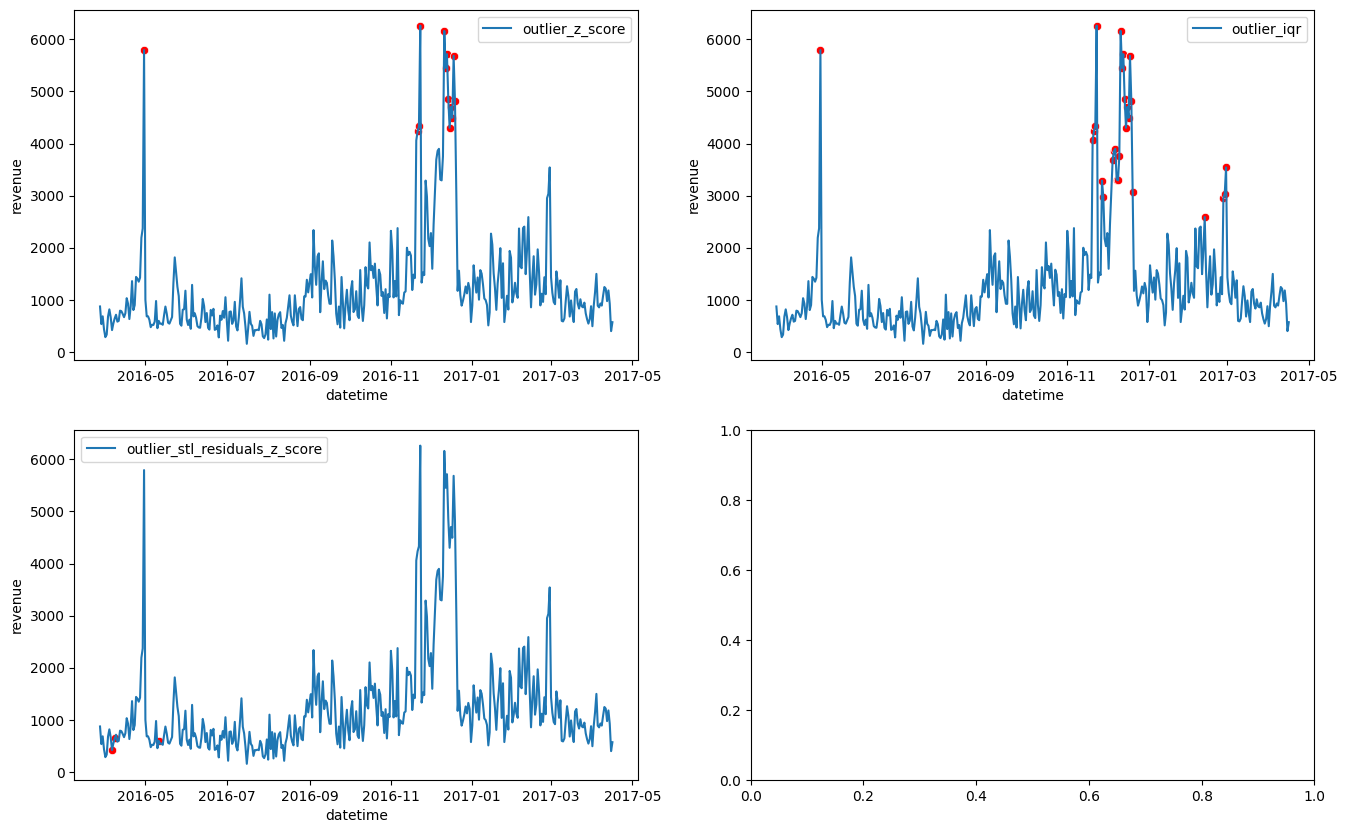

In [25]:
fig, axes = plt.subplots(2,2,figsize=(16,10))
axes = axes.flatten()

for i, outlier in enumerate(["outlier_z_score",
                            "outlier_iqr",
                            "outlier_stl_residuals_z_score"]):

    sns.lineplot(df_revenues, x=df_revenues.index, y="revenue",ax=axes[i],
                label=outlier)
    sns.scatterplot(
        data=df_revenues[df_revenues[outlier]],
        x=df_revenues[df_revenues[outlier]].index,
        y="revenue",
        color="red",
        ax=axes[i]
    )